# Bitcoin: price predictions project

The goal for this project:

Apply two machine learning algorithm to predict Bitcoin(BTC) prices!;
* ARIMA
* rNN

I am using ARIMA and rNN since it is often used for Time Series Forecasting. For this project, I chose to make this a Univariate Regression problem (It could be a multivariate problem), algorithms will be used on the the dataset I've created from web scraping! Please check out 'BTC_Scraper' ipython notebook to see how I created this dataset using Selenium. 

## Dataset

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

btc = pd.read_csv('CMC_BTC_DS.csv')
btc.head()

,Date,Open,High,Low,Close,Volumn
0,"Aug 08, 2020","11,604.55","11,800.06","11,558.43","11,754.05","17,572,057,837"
1,"Aug 07, 2020","11,778.89","11,898.04","11,408.59","11,601.47","23,132,312,867"
2,"Aug 06, 2020","11,749.87","11,902.34","11,598.71","11,779.77","23,400,740,340"
3,"Aug 05, 2020","11,203.82","11,786.62","11,158.29","11,747.02","24,411,254,471"
4,"Aug 04, 2020","11,246.20","11,385.38","11,094.15","11,205.89","21,250,197,042"


I spelt 'Volume' wrong as 'Volumn'.

In [56]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2660 non-null   object
 1   Open    2660 non-null   object
 2   High    2660 non-null   object
 3   Low     2660 non-null   object
 4   Close   2660 non-null   object
 5   Volumn  2660 non-null   object
dtypes: object(6)
memory usage: 124.8+ KB


There are no missing data and the column types are all objects while it should be numerical data. I'll be converting them into numerical type except for 'Date'. 

In [57]:
btc['Date'] = pd.to_datetime(btc['Date'])

# Converts Open/High/Low/Close/Volume column to float data type respectively
btc.Open = btc.Open.astype(str)
btc.Open = btc.Open.str.replace(",","").astype(float)

btc.High = btc.High.astype(str)
btc.High = btc.High.str.replace(",","").astype(float)

btc.Low = btc.Low.astype(str)
btc.Low  = btc.Low.str.replace(",","").astype(float)

btc.Close = btc.Close.astype(str)
btc.Close = btc.Close.str.replace(",","").astype(float)

btc.Volumn = btc.Volumn.astype(str)
btc.Volumn = btc.Volumn.str.replace(",","").astype(float)

The order of the dataframe is in descending order, I want to make it ascending based on the date. 

In [58]:
# Rename the 'Volumn' column
btc = btc.rename(columns={'Volumn':'Volume'})

# Added a new column for the Weighted price
btc['Weighted_price'] = ((btc['High'] + btc['Low'] + btc['Close'])/3)

# Sort 'Date' in ascending order
btc = btc.sort_values('Date')

btc.set_index('Date',inplace=True)

# Checking if all of the modification has desired effect
btc.info()
btc.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2660 entries, 2013-04-28 to 2020-08-08
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            2660 non-null   float64
 1   High            2660 non-null   float64
 2   Low             2660 non-null   float64
 3   Close           2660 non-null   float64
 4   Volume          2660 non-null   float64
 5   Weighted_price  2660 non-null   float64
dtypes: float64(6)
memory usage: 145.5 KB


,Open,High,Low,Close,Volume,Weighted_price
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,0.0,134.096667
2013-04-29,134.44,147.49,134.00,144.54,0.0,142.010000
2013-04-30,144.00,146.93,134.05,139.00,0.0,139.993333
2013-05-01,139.00,139.89,107.72,116.99,0.0,121.533333
2013-05-02,116.38,125.60,92.28,105.21,0.0,107.696667


## Splitting dataset

In [59]:
# After making sure the data type is what I want, I am going to split the dataset into a Train and Test set

# Makes train index 90% of the BTC dataset
train_index = int(np.round(len(btc) * 0.9))

# Makes test index the remaining 10% of the BTC dataset
test_index = int(len(btc) - train_index)

# Sets the first 90% dataset, time sequence to train_set variable
train_set = btc.iloc[:train_index]

# Sets the remaining 10% btc dataset to test_set variable
test_set = btc.iloc[train_index:]

The test set will only be use for the model evaluation. 

Looks like everything is good to go, time to move onto the EDA.

## EDA

Here are what each column means:
* Open: An open candle is when we jump onto another time stamp and starts a new candle at that exact price
* High: High is the max price reached at the specific time stamp candle 
* Low: Low is the min price reached at the specific time stamp candle
* Close: A close candle is whe price reach right before the start of a new candle in the next timestamp
* Volume: Self-explanatory, in USD


Text(0.5, 1.0, 'BTC')

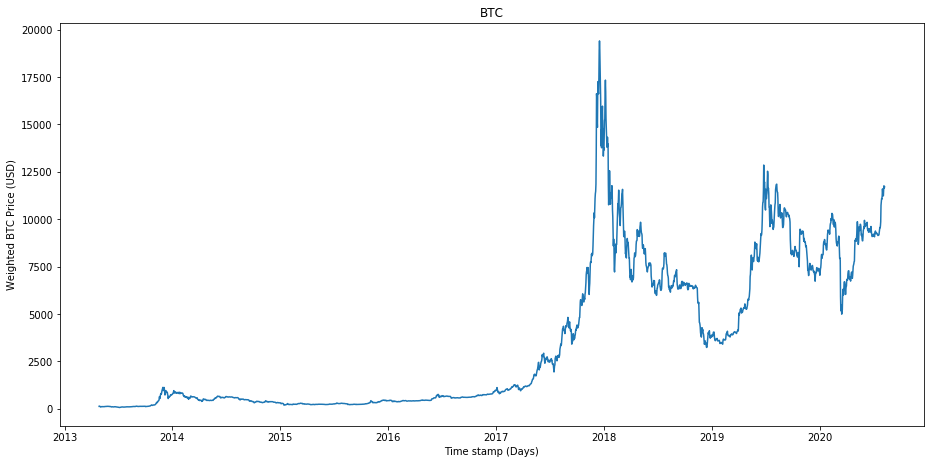

In [60]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=[15,7])

# Add set of axes to figure
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(btc.index, btc.Weighted_price, '-')
axes.set_xlabel('Time stamp (Days)') # Notice the use of set_ to begin methods
axes.set_ylabel('Weighted BTC Price (USD)')
axes.set_title('BTC')

# RNN

A problem with using RNN as a learning algorithms is that it requires more of a clear pattern and knowing bitcoin, there are usually no patterns since it's a highly manipulative asset. As the model tries to forecast further into the future, the errors that it may picked up while trying to forecasting will be magnified the further we try to forecast. I'll prove this by saving a testset and then comparing to the forecasted data. Even though the purpose of rNN is to forecast into the unknown, our unknown will be the tested against the test dataset created by spiting the original dataset into a training and test dataset. Once I'm happy with its performance on the test dataset and it proves that it won't be able to forecast bitcoin's price, i'll determine if I should use it to forecast into the unknown. When I plan on actually forecasting into the unknown, I will retrain my model on ALL of the available data, I won't have data to compare the forecast predictions. 

## Scaling

Because of how rNN works, they're going to feed output back into themselves, we need to scale our label. I never scaled the label themselves before but because we're feeding the output back into themselves we should scale our label. I still plan on scaling to the training dataset only and not include the testset to prevent data leakage.


In [61]:
# Import and create an instance for the scaler, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()

# Had to create new dataframe with the Date and label, which should be sorted by ascending date order already
train = pd.DataFrame(train_set['Weighted_price'])

# Create new dataframe with the Date and label, sorted by ascending date order already
test = pd.DataFrame(test_set['Weighted_price'])


In [62]:
train

,Weighted_price
Date,
2013-04-28,134.096667
2013-04-29,142.010000
2013-04-30,139.993333
2013-05-01,121.533333
2013-05-02,107.696667
...,...
2019-11-12,8784.953333
2019-11-13,8802.250000
2019-11-14,8742.530000


In [63]:
test

,Weighted_price
Date,
2019-11-17,8602.246667
2019-11-18,8412.046667
2019-11-19,8238.210000
2019-11-20,8091.673333
2019-11-21,7783.410000
...,...
2020-08-04,11228.473333
2020-08-05,11563.976667
2020-08-06,11760.273333


In [64]:
# Scaled from training set only to prevent data leakage and any form of cheating
scale.fit(train)

# Transform on train and test sets
train_scaled = scale.transform(train)
test_scaled = scale.transform(test)

## Time series generator

In [65]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Im setting up the length to capture an entire period to hopfully catch any seasonality which is 365 days, 1 year. 
length = 365

# Creating a generator using train_scaled as a source of x, y, length of 365, and feeding in 1 batch at a time. This is required for rNN
generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=1)

In [66]:
# This imports libraries needed to create our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Using only one feature for the time series
n_features = 1

In [67]:
# Model creation
model = Sequential()

# Adding one layer with 100 LSTM specialized neurons with rectified linear unit as the activation function
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

# Final output layer with one neuron
model.add(Dense(1))

# Compiling the model with adam as the variant descent gradient
model.compile(optimizer='adam', loss='mse')

In [68]:
# Shows the final model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Import EarlyStopping to stop the fitting when the val_loss starts to increase instead of decreasing
from tensorflow.keras.callbacks import EarlyStopping

# Variable instance for the early stop function
early_stop = EarlyStopping(monitor= 'val_loss', verbose=2,patience=10)

# Since we used a generator, to forecast, for rNN to used the validation data, the validation data has to be a generator too.
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=265, batch_size=1)

# Use fit_generator instead of fit because rNN requires it to make the batch work
model.fit_generator (generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])


Epoch 1/20
2029/2029 [==============================] - 195s 96ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2/20
2029/2029 [==============================] - 178s 88ms/step - loss: 5.3745e-04 - val_loss: 2.4372e-04
Epoch 3/20
2029/2029 [==============================] - 179s 88ms/step - loss: 5.1003e-04 - val_loss: 1.0616e-04
Epoch 4/20
2029/2029 [==============================] - 156s 77ms/step - loss: 3.7381e-04 - val_loss: 0.0016
Epoch 5/20
2029/2029 [==============================] - 157s 77ms/step - loss: 2.8338e-04 - val_loss: 9.6009e-07
Epoch 6/20
2029/2029 [==============================] - 157s 78ms/step - loss: 2.7646e-04 - val_loss: 1.8447e-04
Epoch 7/20
2029/2029 [==============================] - 153s 75ms/step - loss: 2.6801e-04 - val_loss: 8.1848e-04
Epoch 8/20
2029/2029 [==============================] - 155s 76ms/step - loss: 2.5280e-04 - val_loss: 9.2905e-05
Epoch 9/20
2029/2029 [==============================] - 155s 76ms/step - loss: 2.4105e-04 - val_loss: 6.2661

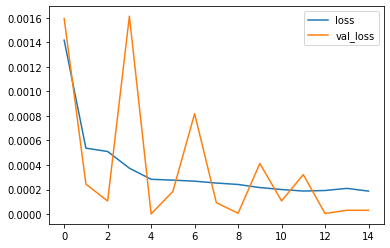

In [70]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on test data

In [71]:
# I'm creating a batch till the begining of the testset so when I compare the forecast and testset, it'll have matching timestamps
first_eval_batch = train_scaled[-length:]

# Reshaping the batch since it needs to have the same shape since rNN expects it. Predicts one timestamp ahead
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [72]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [73]:
# Since the true predictions are scaled, we need to unscale it to compare with the test set that we separated earlier
true_predictions = scale.inverse_transform(test_predictions)

# Creates a new column 'Predictions' onto the test set
test['Predictions'] = true_predictions
test

,Weighted_price,Predictions
Date,,
2019-11-17,8602.246667,8623.622230
2019-11-18,8412.046667,8731.008397
2019-11-19,8238.210000,8831.070645
2019-11-20,8091.673333,8925.114411
2019-11-21,7783.410000,9016.982835
...,...,...
2020-08-04,11228.473333,13355.923661
2020-08-05,11563.976667,13355.959379
2020-08-06,11760.273333,13355.991641


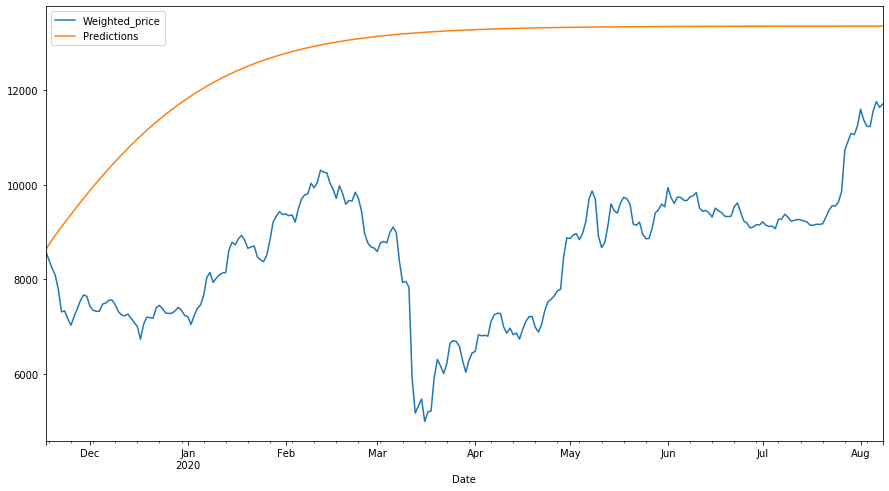

In [74]:
test.plot(figsize=(15,8))

## RNN conclusion

So it's clear that this model wasn't able to forecast bitcoin's price and this was expected. As the model tries to forecast further into the future, the errors that it may picked up while trying to forecasting will be magnified the further we try to forecast because the model will be forecasting the forecast.

What I would usually do is retrain the model on the entire dataset then truely predict into the unknown and then appending the plot onto the end of bitcoin's price chart but it looks like bitcoin's price just plateaued around 16 192.99 and was repeated several time. Retraining on the model will most likely not help with forecasting more accurate bitcoin price. So i'll stop using rNN learning algorithm to predict bitcoin's price. 

There are many things that I could try and improve the model such as:
   * Increase seasonality
   * Add more layers
   * Try dropout function

# ARIMA

An ARIMA (AutoRegressive Integrated Moving Average) model is a class of statistical models for analyzing and forecasting time series data. It assumes that the data becomes stationary after differencing.

The acronyms stand for:
   * AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations. 2.I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
   * MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

Parameters are defined as follows:

   * p: The number of lag observations included in the model, also called the lag order.
   * d: The number of times that the raw observations are differenced, also called the degree of differencing.
   * q: The size of the moving average window, also called the order of moving average.
   

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. It helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.


## Stationarity check and STL-decomposition of the series

In [ ]:
import statsmodels.api as sm

plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(btc.Date, btc.Weighted_price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc.Weighted_price)[1])